In [8]:
import os
import numpy as np

import pandas as pd
import warnings
from sklearn.linear_model import LinearRegression, HuberRegressor, Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
# Set random seed and display settings
np.random.seed(42)
plt.rcParams['figure.figsize'] = (16, 8)
import logging
from sklearn.exceptions import ConvergenceWarning  # Import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)  # Suppress convergence warnings

logging.getLogger("lightgbm").setLevel(logging.ERROR)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [9]:
# Load dataset
file_path = os.path.join(os.getcwd(), "data", "dynamic_pricing.csv")
data = pd.read_csv(file_path)

In [10]:
data

,Number_of_Riders,Number_of_Drivers,Location_Category,Customer_Loyalty_Status,Number_of_Past_Rides,Average_Ratings,Time_of_Booking,Vehicle_Type,Expected_Ride_Duration,Historical_Cost_of_Ride
0,90,45,Urban,Silver,13,4.47,Night,Premium,90,284.257273
1,58,39,Suburban,Silver,72,4.06,Evening,Economy,43,173.874753
2,42,31,Rural,Silver,0,3.99,Afternoon,Premium,76,329.795469
3,89,28,Rural,Regular,67,4.31,Afternoon,Premium,134,470.201232
4,78,22,Rural,Regular,74,3.77,Afternoon,Economy,149,579.681422
...,...,...,...,...,...,...,...,...,...,...
995,33,23,Urban,Gold,24,4.21,Morning,Premium,11,91.389526
996,84,29,Urban,Regular,92,4.55,Morning,Premium,94,424.155987
997,44,6,Suburban,Gold,80,4.13,Night,Premium,40,157.364830
998,53,27,Suburban,Regular,78,3.63,Night,Premium,58,279.095048


In [11]:
# Initial data overview
print("Dataset shape:", data.shape)
# Preprocess categorical columns
categorical_columns = data.select_dtypes(include=['object']).columns
print("Categorical columns:", categorical_columns.tolist())

# One-hot encode categorical variables
data = pd.get_dummies(data, columns=categorical_columns, drop_first=True)

Dataset shape: (1000, 10)
Categorical columns: ['Location_Category', 'Customer_Loyalty_Status', 'Time_of_Booking', 'Vehicle_Type']


In [12]:
new_categorical_columns = [col for col in data.columns if data[col].dtype == 'bool']

print("Categorical columns to convert:", new_categorical_columns)
# Convert only the categorical columns (boolean) to integers
data[new_categorical_columns] = data[new_categorical_columns].astype(int)
# Verify data types of the columns
print(data.dtypes)

# # Ensure values are 0 and 1
# for col in new_categorical_columns:
#     print(f"{col}: {data[col].unique()}")

data = data.sample(frac=1)

Categorical columns to convert: ['Location_Category_Suburban', 'Location_Category_Urban', 'Customer_Loyalty_Status_Regular', 'Customer_Loyalty_Status_Silver', 'Time_of_Booking_Evening', 'Time_of_Booking_Morning', 'Time_of_Booking_Night', 'Vehicle_Type_Premium']
Number_of_Riders                     int64
Number_of_Drivers                    int64
Number_of_Past_Rides                 int64
Average_Ratings                    float64
Expected_Ride_Duration               int64
Historical_Cost_of_Ride            float64
Location_Category_Suburban           int64
Location_Category_Urban              int64
Customer_Loyalty_Status_Regular      int64
Customer_Loyalty_Status_Silver       int64
Time_of_Booking_Evening              int64
Time_of_Booking_Morning              int64
Time_of_Booking_Night                int64
Vehicle_Type_Premium                 int64
dtype: object


In [13]:

# Prepare data
X = data.drop('Historical_Cost_of_Ride', axis=1)

y = data['Historical_Cost_of_Ride']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define models and parameters
models_and_params = {
    "LinearRegression": (LinearRegression(fit_intercept=False), {}),
    "HuberRegressor": (HuberRegressor(fit_intercept=False), {"alpha": np.logspace(-2, 1, 5), "epsilon": [1.35, 1.5, 1.75]}),
    "Lasso": (Lasso(fit_intercept=False), {"alpha": np.logspace(-3, 0, 4)}),
    "Ridge": (Ridge(fit_intercept=False), {"alpha": np.logspace(-2, 1, 5), "solver": ["auto", "svd", "cholesky"]}),
    "ElasticNet": (ElasticNet(fit_intercept=False), {"alpha": np.logspace(-3, 0, 4), "l1_ratio": [0.1, 0.5, 0.9]}),
    "RandomForestRegressor": (
        RandomForestRegressor(),
        {"n_estimators": [50, 100, 200], "max_depth": [None, 10, 20], "min_samples_split": [2, 5, 10]}
    ),
    "GradientBoostingRegressor": (
        GradientBoostingRegressor(),
        {"n_estimators": [50, 100, 200], "learning_rate": [0.01, 0.1, 0.2], "max_depth": [3, 5, 7]}
    ),
    "AdaBoostRegressor": (
        AdaBoostRegressor(),
        {"n_estimators": [50, 100, 200], "learning_rate": [0.01, 0.1, 0.5]}
    ),
    "KNeighborsRegressor": (
        KNeighborsRegressor(),
        {"n_neighbors": [3, 5, 10], "weights": ["uniform", "distance"]}
    ),
    "SVR": (
        SVR(),
        {"C": np.logspace(-2, 2, 5), "epsilon": [0.1, 0.2, 0.5], "kernel": ["linear", "rbf"]}
    ),
    "LinearSVR": (
        LinearSVR(),
        {"C": np.logspace(-3, 2, 5), "epsilon": [0.1, 0.2]}
    ),
    "DecisionTreeRegressor": (
        DecisionTreeRegressor(),
        {"max_depth": [None, 10, 20, 30], "min_samples_split": [2, 5, 10]}
    ),
    "XGBRegressor": (
        XGBRegressor(),
        {"n_estimators": [50, 100, 200], "learning_rate": [0.01, 0.1, 0.2], "max_depth": [3, 5, 7]}
    ),
    "LGBMRegressor": (
        LGBMRegressor(verbose=-1),
        {"n_estimators": [50, 100, 200], "learning_rate": [0.01, 0.1, 0.2], "num_leaves": [31, 50, 100]}
    ),
}

# Re-evaluate models with data and include MAE for test data
results = []
for name, (model, params) in models_and_params.items():
    try:
        grid_search = GridSearchCV(model, params, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        best_score = -grid_search.best_score_  # Convert to positive
        y_test_pred = best_model.predict(X_test)

        # Calculate metrics
        test_mse = mean_squared_error(y_test, y_test_pred)
        test_mae = mean_absolute_error(y_test, y_test_pred)  # Test MAE
        test_r2 = r2_score(y_test, y_test_pred)

        # Extract CV MAE for all hyperparameter combinations
        cv_mae_all = -grid_search.cv_results_["mean_test_score"]  # Convert to positive MAE
        param_combinations = grid_search.cv_results_["params"]

        results.append({
            "Model": name,
            "Mean_CV_MAE": best_score,
            "Test_MAE": test_mae,
            "Test_MSE": test_mse,
            "Test_R2": test_r2,
            "Best_Params": grid_search.best_params_,
            "CV_MAE_All": list(zip(param_combinations, cv_mae_all)),  # Include all CV MAEs with hyperparameters
            "Best_Model": best_model
        })
    except Exception as e:
        print(f"Model {name} failed with error: {e}")

# Convert scaled results to DataFrame
results_df = pd.DataFrame(results)
scaled_results_df = results_df.sort_values(by="Test_MAE")

# Display scaled results
print(results_df[["Model", "Mean_CV_MAE", "Test_MAE", "Test_MSE", "Test_R2"]])

# Example: Access all CV MAE for the top model
top_model_cv_mae = results_df.iloc[0]["CV_MAE_All"]
print(f"\nAll CV MAE for top model ({results_df.iloc[0]['Model']}):")
for params, cv_mae in top_model_cv_mae:
    print(f"Params: {params}, CV MAE: {cv_mae}")

/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_huber.py:343: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_huber.py:343: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_huber.py:343: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Inc

Model XGBRegressor failed with error: 'super' object has no attribute '__sklearn_tags__'


/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not 

                        Model  Mean_CV_MAE   Test_MAE     Test_MSE   Test_R2
0            LinearRegression    52.363491  50.849894  4263.014365  0.884841
1              HuberRegressor    52.122650  50.748019  4274.583298  0.884528
2                       Lasso    51.889670  50.319286  4242.067139  0.885407
3                       Ridge    52.264829  50.805516  4264.353372  0.884805
4                  ElasticNet    52.175695  50.768140  4279.824363  0.884387
5       RandomForestRegressor    52.475949  53.024551  4950.191104  0.866278
6   GradientBoostingRegressor    52.995046  52.594410  4757.738505  0.871476
7           AdaBoostRegressor    55.338850  55.691503  4833.876350  0.869420
8         KNeighborsRegressor    57.779301  58.447883  5463.234888  0.852418
9                         SVR    52.150566  51.029759  4321.126742  0.883271
10                  LinearSVR    53.014461  51.699839  4446.987441  0.879871
11      DecisionTreeRegressor    61.237990  66.839101  8046.306829  0.782640

In [15]:
# Extract the top-performing model
top_model_row = scaled_results_df.iloc[0]
top_model_name = top_model_row["Model"]
top_model = top_model_row["Best_Model"]

# Check if the model is linear (e.g., LinearRegression, Lasso, Ridge, ElasticNet, HuberRegressor)
if hasattr(top_model, "coef_") and hasattr(top_model, "intercept_"):
    coefficients = top_model.coef_  # Coefficients of the features
    intercept = top_model.intercept_  # Intercept of the equation

    # Get feature names from the dataset
    feature_names = X_train.columns

    # Construct the equation, excluding terms with zero coefficients
    terms = [f"{coef:.4f} * {feature}" for coef, feature in zip(coefficients, feature_names) if coef != 0]
    equation = "y = " + " + ".join(terms) + f" + {intercept:.4f}"

    print(f"Best Model: {top_model_name}")
    print("Best Equation:")
    print(equation)

else:
    print(f"The best model '{top_model_name}' does not provide coefficients. It may not be a linear model.")
# Extract the top-performing model
top_model_row = scaled_results_df.iloc[0]
top_model_name = top_model_row["Model"]
top_model = top_model_row["Best_Model"]
top_model_params = top_model_row["Best_Params"]

# Print the best model details
print(f"Best Model: {top_model_name}")
print(f"Best Parameters: {top_model_params}")
# Make predictions
predictions = top_model.predict(X_test)

Best Model: Lasso
Best Equation:
y = -0.1398 * Number_of_Riders + 0.4665 * Number_of_Drivers + -0.0033 * Number_of_Past_Rides + 3.4973 * Expected_Ride_Duration + -2.4212 * Time_of_Booking_Evening + 39.5754 * Vehicle_Type_Premium + 0.0000
Best Model: Lasso
Best Parameters: {'alpha': np.float64(1.0)}


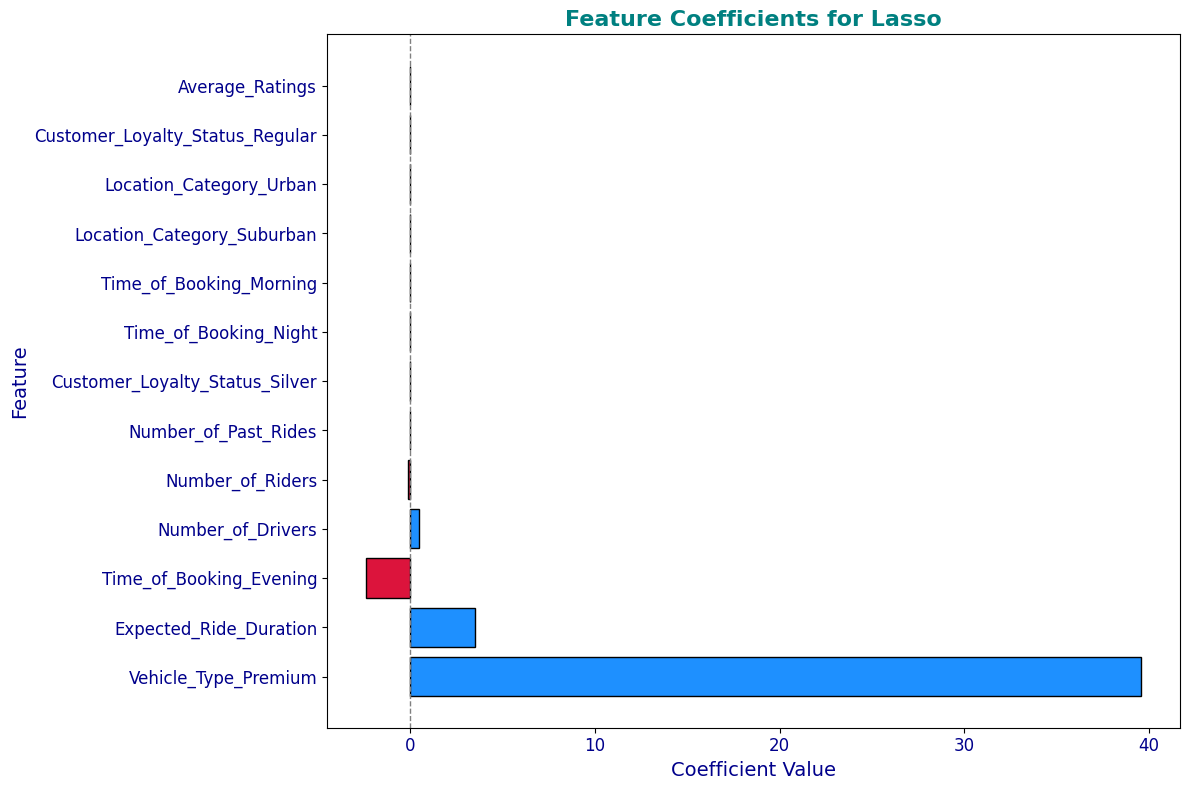

In [16]:
# Ensure the model has coefficients
if hasattr(top_model, "coef_") and hasattr(top_model, "intercept_"):
    # Extract coefficients and feature names
    coefficients = top_model.coef_
    feature_names = X_train.columns

    # Sort coefficients by magnitude for better visualization
    sorted_indices = np.argsort(np.abs(coefficients))[::-1]
    sorted_coefficients = coefficients[sorted_indices]
    sorted_feature_names = feature_names[sorted_indices]

    # Plot coefficients
    plt.figure(figsize=(12, 8))
    colors = ['dodgerblue' if coef > 0 else 'crimson' for coef in sorted_coefficients]

    plt.barh(sorted_feature_names, sorted_coefficients, color=colors, edgecolor='black')
    plt.axvline(0, color="gray", linestyle="--", linewidth=1)  # Add a line at 0 for reference

    # Add labels and title
    plt.xlabel("Coefficient Value", fontsize=14, color="darkblue")
    plt.ylabel("Feature", fontsize=14, color="darkblue")
    plt.title(f"Feature Coefficients for {top_model_name}", fontsize=16, fontweight="bold", color="teal")

    # Beautify ticks
    plt.xticks(fontsize=12, color="darkblue")
    plt.yticks(fontsize=12, color="darkblue")

    # Tight layout
    plt.tight_layout()
    plt.show()

else:
    print(f"The best model '{top_model_name}' does not provide coefficients. It may not be a linear model.")

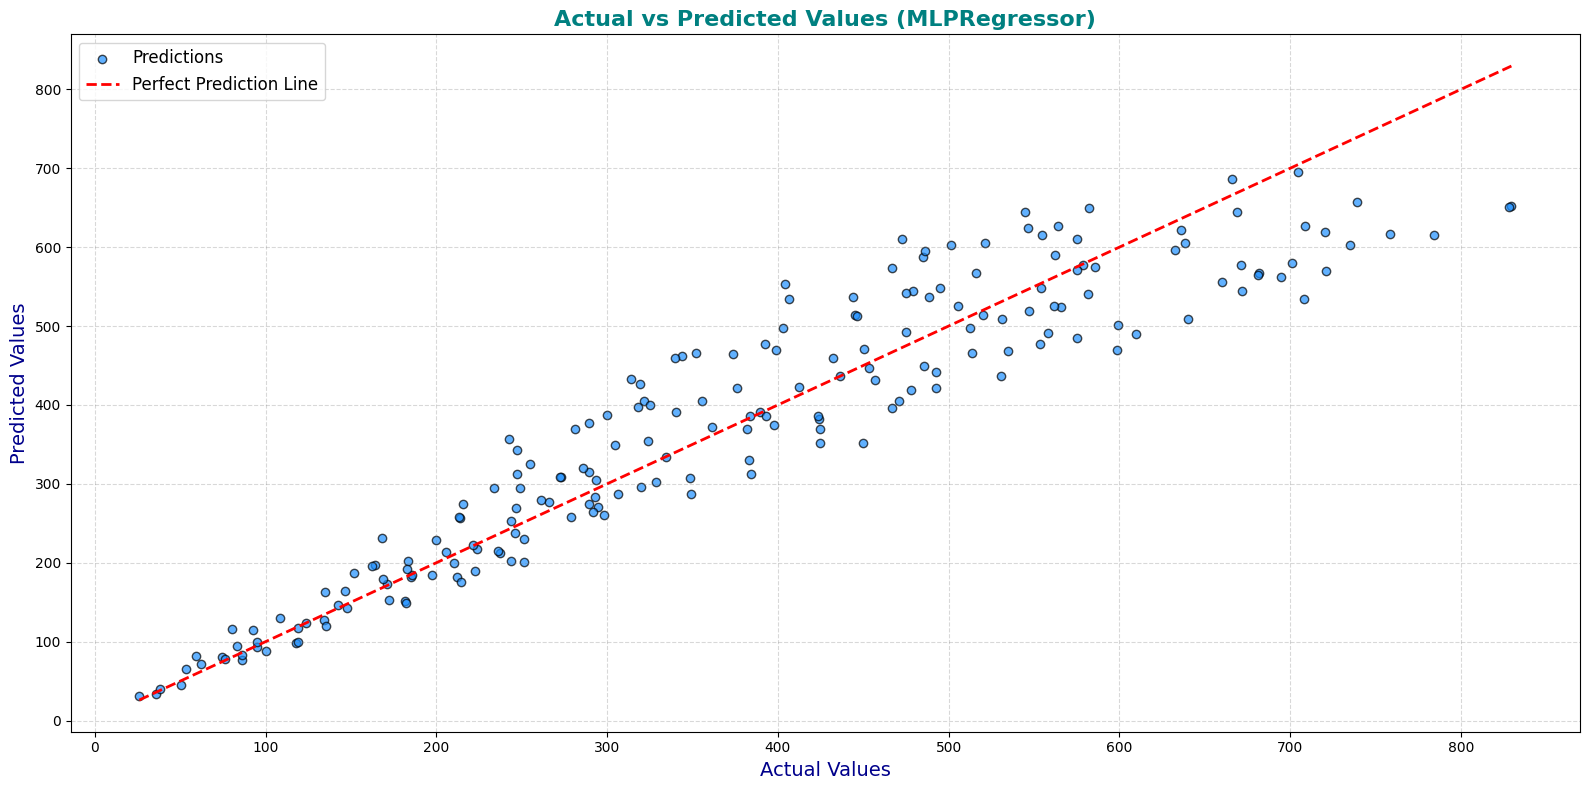

In [9]:
# Enhanced Actual vs Predicted Values Plot
plt.figure(figsize=(16, 8))

# Scatter plot
plt.scatter(y_test, predictions, alpha=0.7, edgecolor='k', label="Predictions", color="dodgerblue")

# Perfect Prediction Line
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    '--r',
    label="Perfect Prediction Line",
    linewidth=2
)

# Additional aesthetics
plt.xlabel("Actual Values", fontsize=14, color="darkblue")
plt.ylabel("Predicted Values", fontsize=14, color="darkblue")
plt.title(f"Actual vs Predicted Values ({top_model_name})", fontsize=16, fontweight="bold", color="teal")
plt.legend(fontsize=12, loc="upper left")
plt.grid(alpha=0.3, linestyle='--', color='gray')
plt.tight_layout()

plt.show()

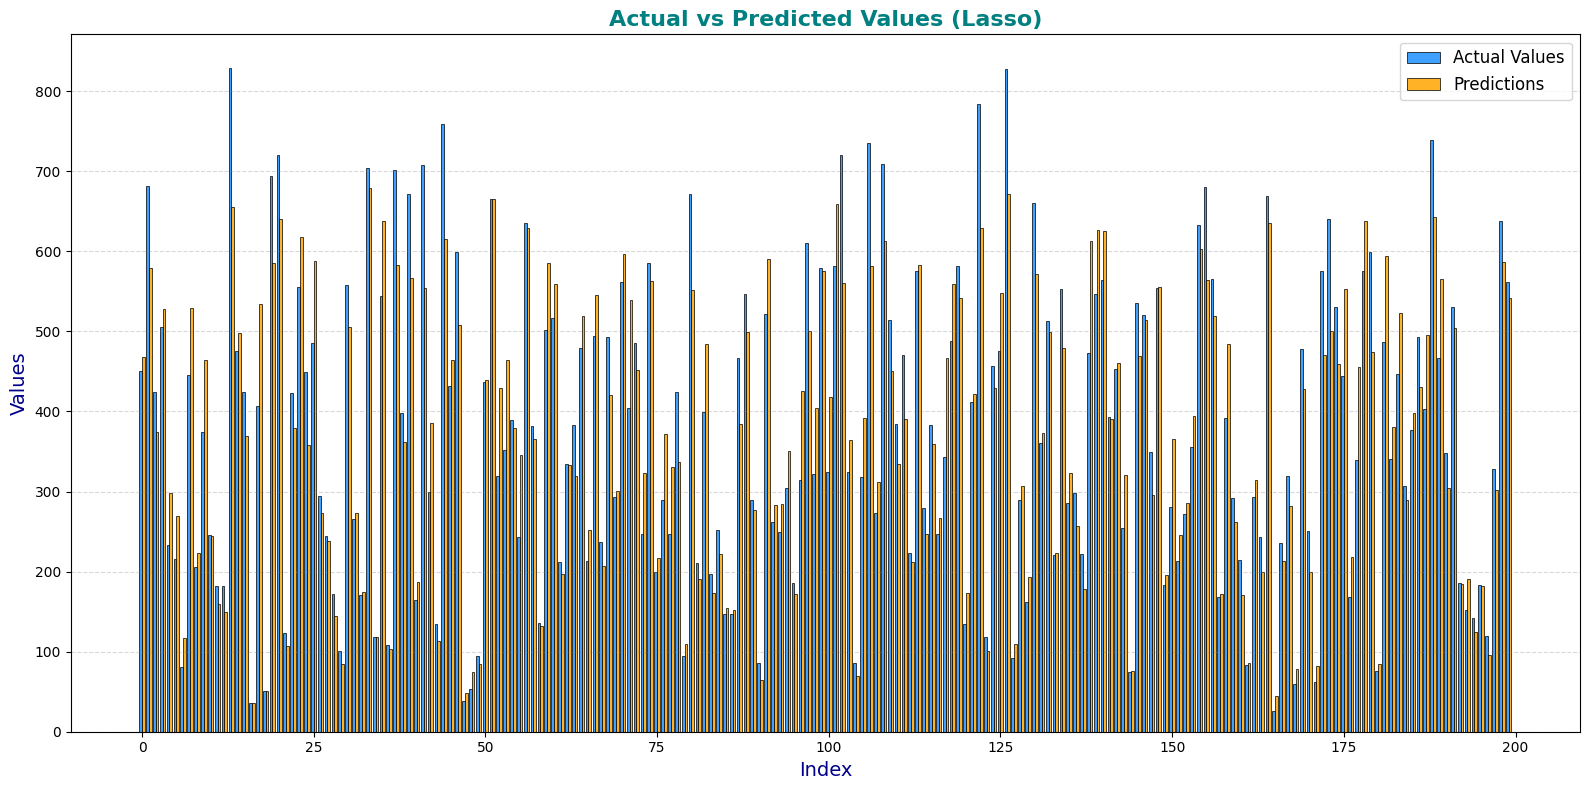

In [17]:
# Create a range for the x-axis
x = np.arange(len(y_test))

# Enhanced Bar Plot for Actual vs Predicted Values
plt.figure(figsize=(16, 8))

# Actual Values Bar
plt.bar(
    x - 0.2,
    y_test,
    width=0.4,
    label='Actual Values',
    alpha=0.85,
    color='dodgerblue',
    edgecolor='k',
    linewidth=0.6
)

# Predicted Values Bar
plt.bar(
    x + 0.2,
    predictions,
    width=0.4,
    label='Predictions',
    alpha=0.85,
    color='orange',
    edgecolor='k',
    linewidth=0.6
)

# Add Labels and Title
plt.xlabel("Index", fontsize=14, color="darkblue")
plt.ylabel("Values", fontsize=14, color="darkblue")
plt.title(f"Actual vs Predicted Values ({top_model_name})", fontsize=16, fontweight="bold", color="teal")

# Add Legend
plt.legend(fontsize=12, loc="upper right")

# Add Grid
plt.grid(axis='y', alpha=0.3, linestyle='--', color='gray')

# Improve Layout
plt.tight_layout()

# Show Plot
plt.show()

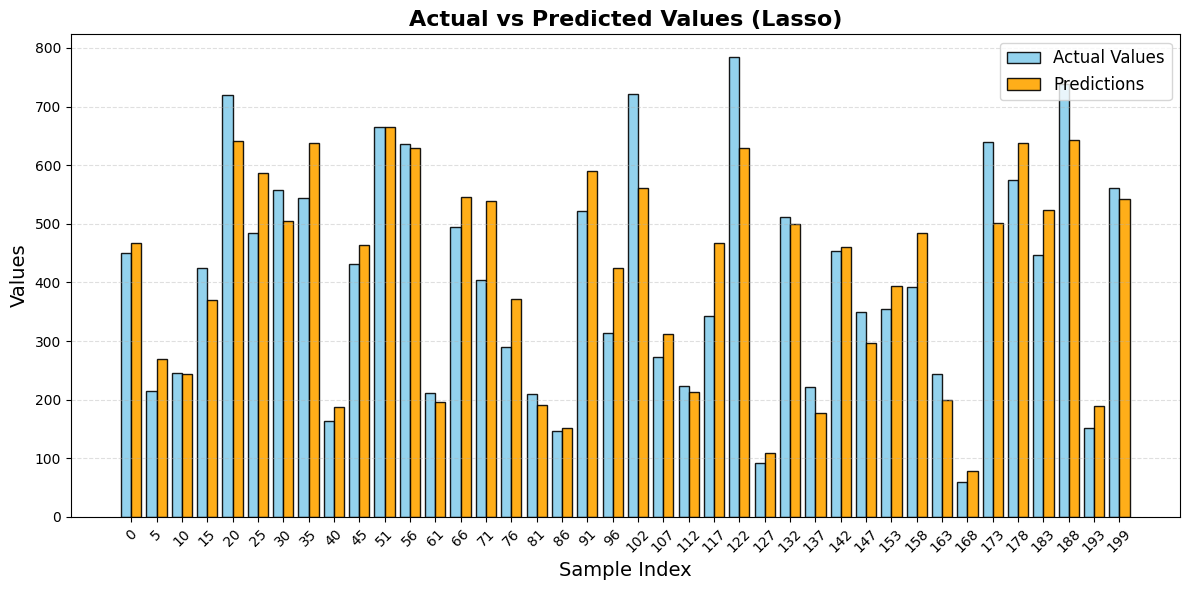

In [18]:
# Define the number of bars to display
sample_size = int(len(y_test)*0.2)  # Adjust the sample size to reduce clutter

# Create sampled indices for both actual and predicted values
indices = np.linspace(0, len(y_test) - 1, sample_size, dtype=int)
x = np.arange(len(indices))

# Extract samples for plotting
y_test_sample = np.array(y_test)[indices]
predictions_sample = np.array(predictions)[indices]

# Enhanced Bar Plot for Actual vs Predicted Values
plt.figure(figsize=(12, 6))

# Actual Values Bar
plt.bar(
    x - 0.2,
    y_test_sample,
    width=0.4,
    label='Actual Values',
    alpha=0.9,
    color='skyblue',
    edgecolor='black'
)

# Predicted Values Bar
plt.bar(
    x + 0.2,
    predictions_sample,
    width=0.4,
    label='Predictions',
    alpha=0.9,
    color='orange',
    edgecolor='black'
)

# Add Labels and Title
plt.xlabel("Sample Index", fontsize=14)
plt.ylabel("Values", fontsize=14)
plt.title(f"Actual vs Predicted Values ({top_model_name})", fontsize=16, fontweight="bold")

# Customize x-axis ticks
plt.xticks(x, indices, rotation=45, fontsize=10)

# Add Legend
plt.legend(fontsize=12, loc="best")

# Add Grid
plt.grid(axis='y', alpha=0.4, linestyle='--')

# Optimize Layout
plt.tight_layout()

# Show Plot
plt.show()


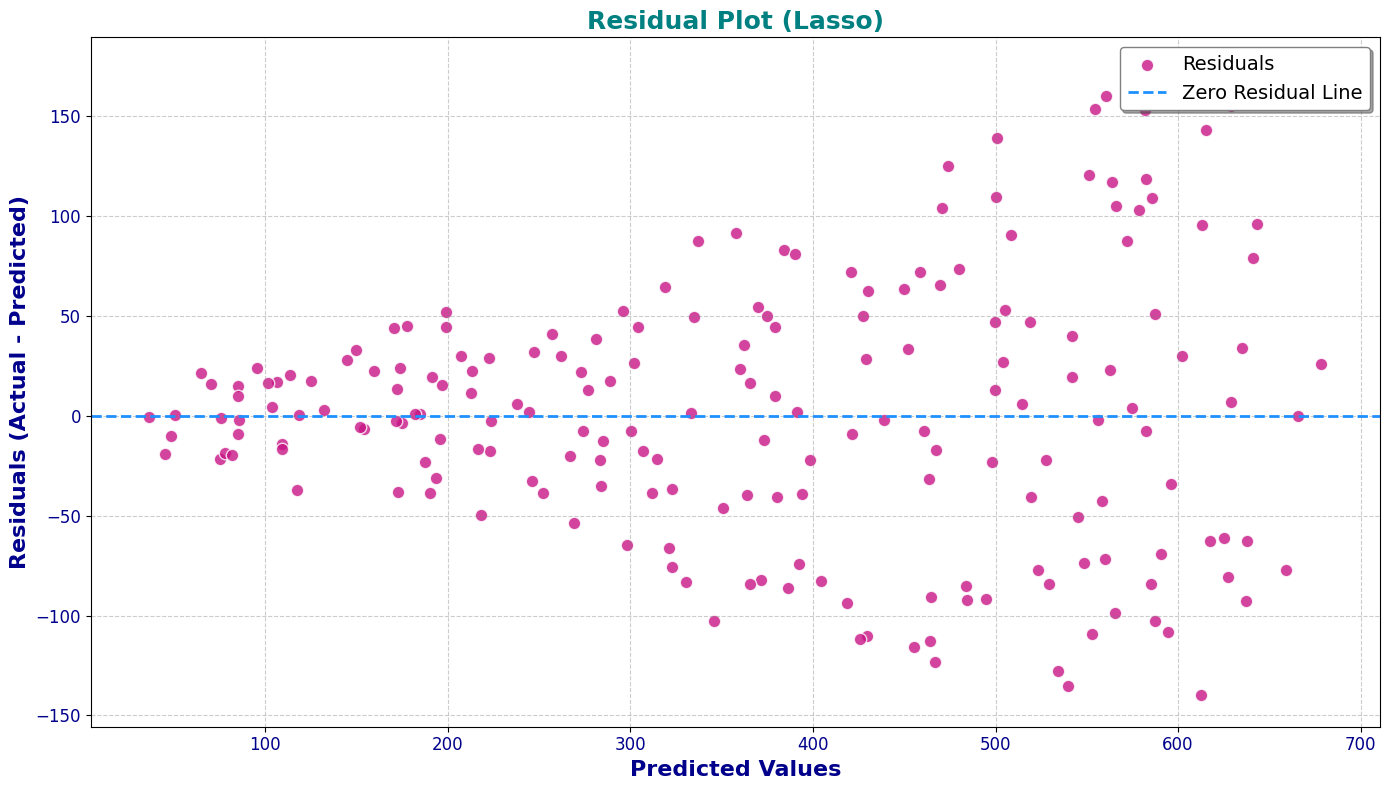

In [19]:
# Calculate residuals
residuals = y_test - predictions

# Pretty Residual Plot
plt.figure(figsize=(14, 8))

# Scatter plot for residuals
plt.scatter(
    predictions,
    residuals,
    alpha=0.8,
    edgecolor='white',
    color='mediumvioletred',
    s=80,  # Increase marker size
    label="Residuals"
)

# Zero residual reference line
plt.axhline(0, color='dodgerblue', linestyle='--', linewidth=2, label="Zero Residual Line")

# Labels and title
plt.xlabel("Predicted Values", fontsize=16, fontweight='bold', color="darkblue")
plt.ylabel("Residuals (Actual - Predicted)", fontsize=16, fontweight='bold', color="darkblue")
plt.title(f"Residual Plot ({top_model_name})", fontsize=18, fontweight="bold", color="teal")

# Legend
plt.legend(fontsize=14, loc="upper right", frameon=True, shadow=True, facecolor='white', edgecolor='gray')

# Grid for clarity
plt.grid(alpha=0.4, linestyle='--', color='gray')

# Beautify axes
plt.xticks(fontsize=12, color="darkblue")
plt.yticks(fontsize=12, color="darkblue")

# Improve layout
plt.tight_layout()

# Show plot
plt.show()

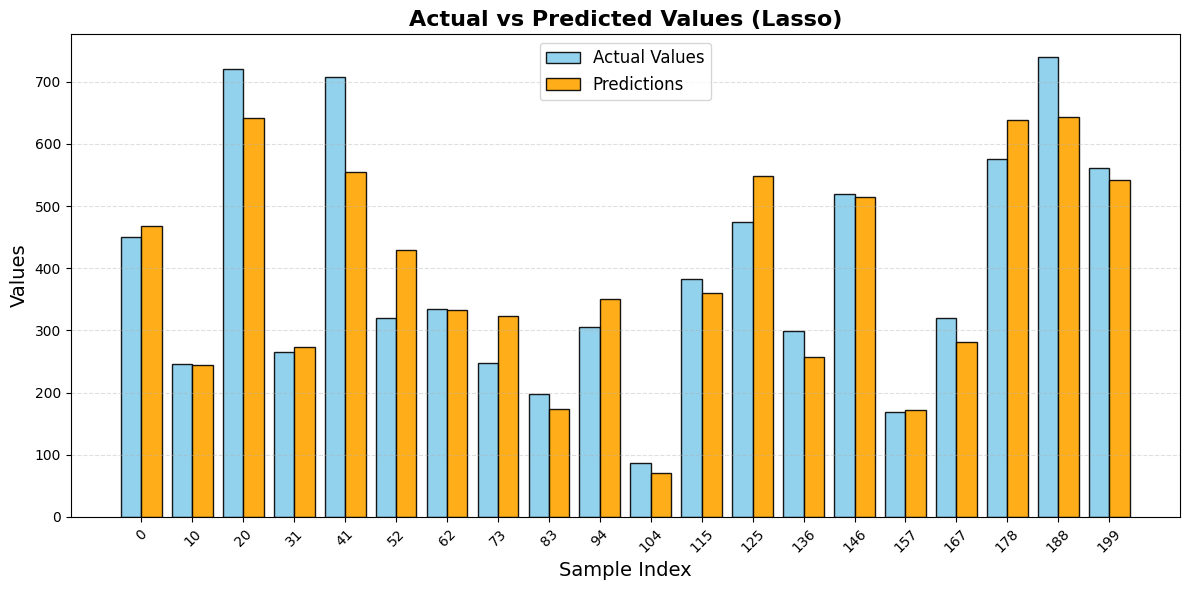

In [ ]:
# Define the number of bars to display
sample_size = 20  # Adjust the sample size to reduce clutter

# Create sampled indices for both actual and predicted values
indices = np.linspace(0, len(y_test) - 1, sample_size, dtype=int)
x = np.arange(len(indices))

# Extract samples for plotting
y_test_sample = np.array(y_test)[indices]
predictions_sample = np.array(predictions)[indices]

# Enhanced Bar Plot for Actual vs Predicted Values
plt.figure(figsize=(12, 6))

# Actual Values Bar
plt.bar(
    x - 0.2,
    y_test_sample,
    width=0.4,
    label='Actual Values',
    alpha=0.9,
    color='skyblue',
    edgecolor='black'
)

# Predicted Values Bar
plt.bar(
    x + 0.2,
    predictions_sample,
    width=0.4,
    label='Predictions',
    alpha=0.9,
    color='orange',
    edgecolor='black'
)

# Add Labels and Title
plt.xlabel("Sample Index", fontsize=14)
plt.ylabel("Values", fontsize=14)
plt.title(f"Actual vs Predicted Values ({top_model_name})", fontsize=16, fontweight="bold")

# Customize x-axis ticks
plt.xticks(x, indices, rotation=45, fontsize=10)

# Add Legend
plt.legend(fontsize=12, loc="best")

# Add Grid
plt.grid(axis='y', alpha=0.4, linestyle='--')

# Optimize Layout
plt.tight_layout()

# Show Plot
plt.show()


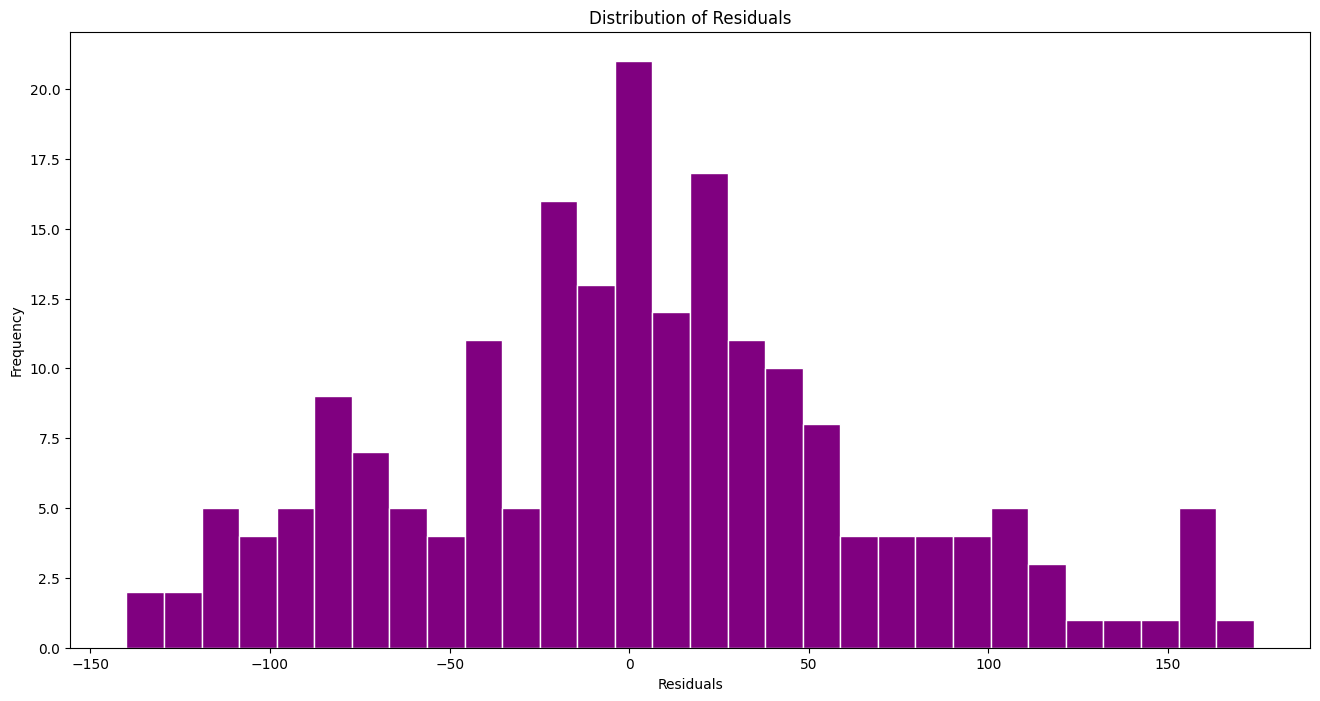

In [21]:
plt.hist(residuals, bins=30, color="purple", edgecolor="white")
plt.title("Distribution of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

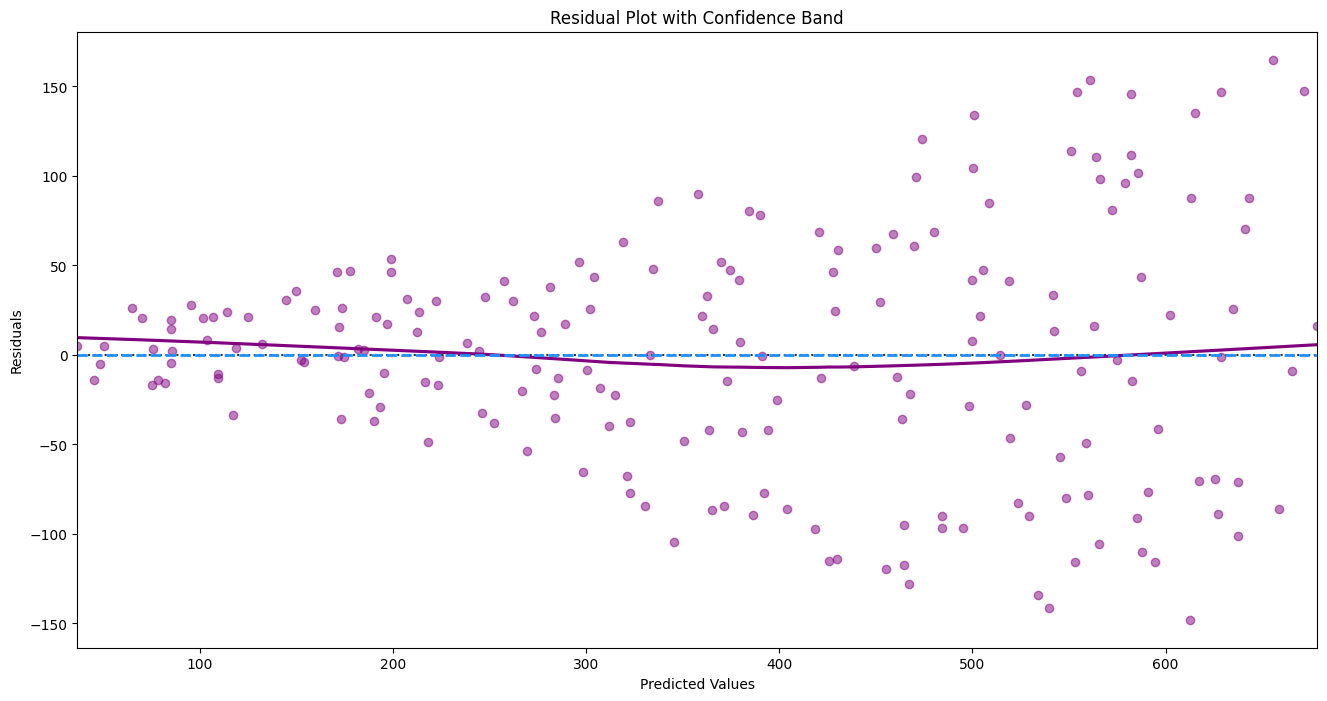

In [22]:
# Plot residuals with KDE for confidence
sns.residplot(x=predictions, y=residuals, lowess=True, color="purple", scatter_kws={'alpha':0.5})
plt.axhline(0, color='dodgerblue', linestyle='--', linewidth=2)
plt.title("Residual Plot with Confidence Band")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.show()